## DataSetProcess

# Text Classification

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# coding: UTF-8
import torch
import numpy as np
from importlib import import_module
import pandas as pd
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
import torch.nn as nn
from sklearn.metrics import accuracy_score
glove = GloVe(name='6B', dim=300)
import nltk
from string import punctuation
def cut_word(sentence):
    tokens = nltk.word_tokenize(sentence)
    tokens_without_punct = [word.lower() for word in tokens if word not in punctuation]
    return ' '.join(tokens_without_punct)  

def sentence_to_vector(word_list):
    tensor = glove.get_vecs_by_tokens(word_list.split(' '), True).numpy().tolist()
    for i in range(100-len(tensor)):
        tensor.append([0]*300)
    return tensor

In [2]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')
dev_data = pd.read_csv('./dataset/dev.csv')
rawdata = pd.concat([train_data,test_data,dev_data])
rawdata.index = range(len(rawdata))
rawdata

,text,label
0,If symptomatic patient got the vaccine will he...,0
1,"Has anyone died from getting the Pfizer, Moder...",0
2,Why should I trust a pharmaceutical company wh...,0
3,What are antisense RNA's? Could they or dsRNA...,0
4,The vaccines aren't FDA approved.,0
...,...,...
3017,Is it advisable to get a vaccine 15 days after...,3
3018,where can i get vaccinated,3
3019,Thinking of getting J &J. Have history of DVTs...,3
3020,Can I get a booster?,3


### Make Datasets

In [3]:
train_label_index=np.array(list(range(len(train_data))))
dev_label_index=np.array(list(range(len(train_data),len(train_data)+len(dev_data))))
test_label_index=np.array(list(range(len(train_data)+len(dev_data),len(train_data)+len(dev_data)+len(test_data))))
np.random.shuffle(train_label_index)
np.random.shuffle(dev_label_index)

In [4]:
data=rawdata[['label','text']]
data['text']=data['text'].apply(lambda x:x[:100]) # seq_length
data.columns=['labels','texts']
data.head()

,labels,texts
0,0,If symptomatic patient got the vaccine will he...
1,0,"Has anyone died from getting the Pfizer, Moder..."
2,0,Why should I trust a pharmaceutical company wh...
3,0,What are antisense RNA's? Could they or dsRNA...
4,0,The vaccines aren't FDA approved.


In [5]:
data['word_list']=data.texts.apply(cut_word)
data

,labels,texts,word_list
0,0,If symptomatic patient got the vaccine will he...,if symptomatic patient got the vaccine will he...
1,0,"Has anyone died from getting the Pfizer, Moder...",has anyone died from getting the pfizer modern...
2,0,Why should I trust a pharmaceutical company wh...,why should i trust a pharmaceutical company wh...
3,0,What are antisense RNA's? Could they or dsRNA...,what are antisense rna 's could they or dsrna ...
4,0,The vaccines aren't FDA approved.,the vaccines are n't fda approved
...,...,...,...
3017,3,Is it advisable to get a vaccine 15 days after...,is it advisable to get a vaccine 15 days after...
3018,3,where can i get vaccinated,where can i get vaccinated
3019,3,Thinking of getting J &J. Have history of DVTs...,thinking of getting j j have history of dvts a...
3020,3,Can I get a booster?,can i get a booster


### Glove embedding pre training word encoding maps each word to a vector of 300

### Pytorch DataLoader

In [6]:
import torch.utils.data as Data
class MyDataSet(Data.Dataset):
    def __init__(self, data):
        self.x = data['word_list'].values
        self.y = data.labels.values

    def __getitem__(self, index):
        return np.array(sentence_to_vector(self.x[index]),dtype=np.float32),self.y[index]

    def __len__(self):
        return len(self.x)
dataset = MyDataSet(data)

batch_size=100
train_iter = Data.DataLoader(dataset, batch_size=batch_size,shuffle=False, drop_last=False, sampler=train_label_index)
dev_iter = Data.DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=False, sampler=dev_label_index)
test_iter = Data.DataLoader(dataset, batch_size=3000, shuffle=False,drop_last=False, sampler=test_label_index)

model_name ='TextRNN_Att' 

In [7]:
# Set model parameters
x = import_module(f'models.{model_name}')
config = x.Config()
config.num_classes = 4
config.learning_rate = 0.001
config.num_epochs = 30

# Load Model
model = x.Model(config).to(config.device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
loss_func = nn.CrossEntropyLoss()

In [8]:
# Record losses and accuracy during training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

train_loss_record = []
train_acc_record = []
test_loss_record = []
test_acc_record = []

# Training
for epoch in range(config.num_epochs):
    print(f'Epoch [{epoch + 1}/{config.num_epochs}]')
    model.train()  # 
    for i, (inputs, targets) in enumerate(train_iter):
        inputs, targets = inputs.to(config.device), targets.to(config.device)
        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = loss_func(outputs, targets) 
        loss.backward()  
        optimizer.step()  
        train_preds = torch.argmax(outputs, axis=1)
        train_acc = accuracy_score(train_preds.cpu(), targets.cpu())
        train_loss_list.append(loss.item())
        train_acc_list.append(train_acc)
# Eval
    model.eval()  
    with torch.no_grad():
        test_loss_total = 0
        test_acc_total = 0
        test_count = 0
        for inputs, targets in dev_iter:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = model(inputs)
            test_loss = loss_func(outputs, targets).item()
            test_preds = torch.argmax(outputs, axis=1)
            test_acc = accuracy_score(test_preds.cpu(), targets.cpu())
            test_loss_total += test_loss
            test_acc_total += test_acc
            test_count += 1
        test_loss_avg = test_loss_total / test_count
        test_acc_avg = test_acc_total / test_count
        test_loss_list.append(test_loss_avg)
        test_acc_list.append(test_acc_avg)

    train_loss_record.append(train_loss_list[-1])
    train_acc_record.append(train_acc_list[-1])
    test_loss_record.append(test_loss_list[-1])
    test_acc_record.append(test_acc_list[-1])

    print(f'Training Loss: {train_loss_list[-1]:.4f}, Training Acc: {train_acc_list[-1]:.4f}',f'Evaling Loss: {test_loss_list[-1]:.4f}, Evaling Acc: {test_acc_list[-1]:.4f}')

Epoch [1/30]
Training Loss: 0.9403, Training Acc: 0.5333 Evaling Loss: 1.2541, Evaling Acc: 0.2241
Epoch [2/30]
Training Loss: 1.0354, Training Acc: 0.5333 Evaling Loss: 1.2903, Evaling Acc: 0.2241
Epoch [3/30]
Training Loss: 0.8759, Training Acc: 0.4667 Evaling Loss: 1.1998, Evaling Acc: 0.2174
Epoch [4/30]
Training Loss: 0.7875, Training Acc: 0.4667 Evaling Loss: 1.1467, Evaling Acc: 0.5954
Epoch [5/30]
Training Loss: 0.6630, Training Acc: 0.8000 Evaling Loss: 0.9448, Evaling Acc: 0.6623
Epoch [6/30]
Training Loss: 0.3791, Training Acc: 0.9333 Evaling Loss: 0.8995, Evaling Acc: 0.7125
Epoch [7/30]
Training Loss: 0.4454, Training Acc: 0.8000 Evaling Loss: 1.0586, Evaling Acc: 0.6791
Epoch [8/30]
Training Loss: 0.2193, Training Acc: 0.9333 Evaling Loss: 0.8866, Evaling Acc: 0.7159
Epoch [9/30]
Training Loss: 0.1378, Training Acc: 1.0000 Evaling Loss: 0.9815, Evaling Acc: 0.6959
Epoch [10/30]
Training Loss: 0.1065, Training Acc: 1.0000 Evaling Loss: 0.9052, Evaling Acc: 0.7092
Epoch [11

In [9]:
# Save the losses and accuracy during training to DataFrame
records = pd.DataFrame({
    'Train Loss': train_loss_record,
    'Train Acc': train_acc_record,
    'Eval Loss': test_loss_record,
    'Eval Acc': test_acc_record
})

In [10]:
records

,Train Loss,Train Acc,Eval Loss,Eval Acc
0,0.940324,0.533333,1.254119,0.224074
1,1.035448,0.533333,1.290286,0.224074
2,0.875876,0.466667,1.199792,0.217407
3,0.787545,0.466667,1.146730,0.595421
4,0.663024,0.800000,0.944795,0.662256
5,0.379091,0.933333,0.899523,0.712458
6,0.445379,0.800000,1.058634,0.679091
7,0.219285,0.933333,0.886647,0.715892
8,0.137798,1.000000,0.981541,0.695859
9,0.106466,1.000000,0.905241,0.709226


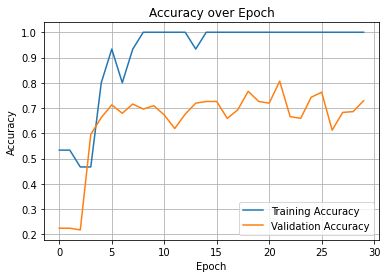

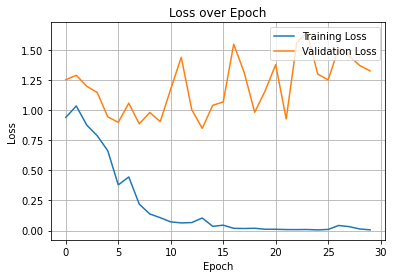

In [25]:
import matplotlib.pyplot as plt

# 设置图形尺寸
plt.plot(records['Train Acc'], label='Training Accuracy')
plt.plot(records['Eval Acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epoch')
plt.grid()
plt.savefig('Accuracy.png')
plt.show()
plt.clf()
plt.plot(records['Train Loss'], label='Training Loss')
plt.plot(records['Eval Loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss over Epoch')
plt.savefig('Loss.png')

# 显示图形
plt.show()

In [14]:
with torch.no_grad():
    for tests, labels in test_iter:
        tests, labels = tests.cuda().float(), labels.long().cuda()
        outputs = model(tests)  # 10,73->10,5
        test_preds = torch.argmax(outputs, axis=1)

In [15]:
groundtruth, predict = labels.cpu().numpy(), test_preds.cpu().numpy()

In [16]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
label_column = ['Low Institutional Trust', 'Low Agent Trust', 'Neutral', 'High Trust']
report=classification_report(groundtruth, predict,target_names=label_column,output_dict=True)
report = pd.DataFrame(report)
report.to_csv('./result.csv')
report

,Low Institutional Trust,Low Agent Trust,Neutral,High Trust,accuracy,macro avg,weighted avg
precision,0.483333,0.0,0.930818,0.812081,0.849119,0.556558,0.872412
recall,0.794521,0.0,0.865497,0.817568,0.849119,0.619396,0.849119
f1-score,0.601036,0.0,0.896970,0.814815,0.849119,0.578205,0.856823
support,73.000000,3.0,684.000000,148.000000,0.849119,908.000000,908.000000


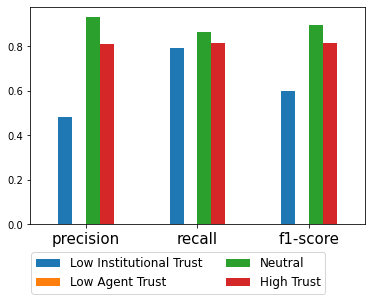

In [26]:
plt.figure(figsize=(6,4))
report.T.iloc[:4,:3].T.plot.bar(rot=0,ax=plt.gca())
plt.legend(fontsize=12,bbox_to_anchor=(0.90,-0.10),ncol=2)
plt.xticks(size=15)
plt.savefig('Compare.png')
plt.show()

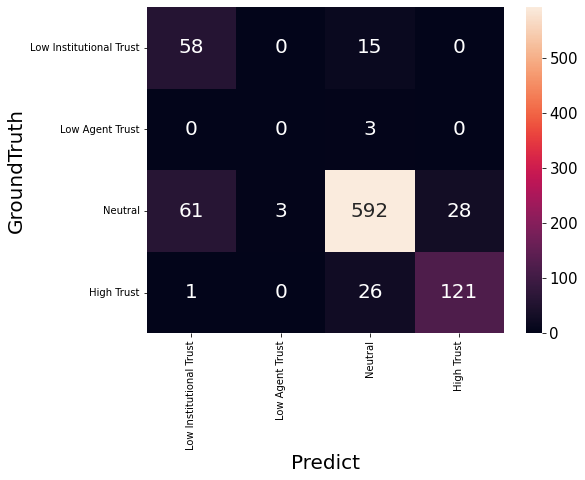

In [27]:
cm = confusion_matrix(groundtruth, predict)#
ax = sns.heatmap(cm,annot=True,fmt='g',xticklabels=label_column,yticklabels=label_column,annot_kws={"fontsize":20})
#xticklabels、yticklabels
ax.set_xlabel('Predict',size=20) #x
ax.set_ylabel('GroundTruth',size=20) #y
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.gcf().set_size_inches(8, 6)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.savefig('Confusion_Matrix.png')
plt.show() 